In [1]:
%matplotlib notebook                      
import numpy as np                        # working with arrays
import imageio                            # reading images as an array
import matplotlib.pyplot as plt           # working with plots


from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import warnings

Xmin = -50             # reactor boundaries
Xmax = +50
Ymin = -50
Ymax = +50

Xsize = Xmax-Xmin       # size of the X_Y grid
Ysize = Ymax-Ymin    
dx  = 0.5                 # space step in nm
dy  = dx                # dx = 8.5 nm

nX  = int(Xsize/dx)     # integer
nY  = int(Ysize/dy)

T  = 5000              # total time
dt = 0.25                  # time step
nt = int(T/dt)          # number of iterations

f      = 0.073          # equilibrium rate constant  
k_sol  = 0.1345         # solidification rate

I_cr = 7.5              # quenching parameters
h = 45

delta = 1.95
Ds1i = 0.112            # diffusion constants 
Ds2i = Ds1i/delta
Di   = 0.24

CFLx = Di*dt/(dx**2)    # CFL satbility criterion

mag_facf = 104
mf=mag_facf
Xm,XM,Ym,YM =(Xmin/dx)/mf,(Xmax/dx)/mf,(Ymax/dx)/mf,(Ymin/dx)/mf
ds0 = 1

if (CFLx > 0.24 ) : warnings.warn("\n  CFL* HAS BEEN REACHED: CFL={:.3f}".format(CFLx))

print('Grid size (rows):...................{}'.format(nY))
print('Estimated simulation time (min):....{:.2f}'.format((4.5e-4*nX+5.12e-3)**2.3*T/dt/60)) # empirical func.
print('CFL (CFL*=0.16):....................{:.3f}'.format(CFLx))

Grid size (rows):...................200
Estimated simulation time (min):....1.49
CFL (CFL*=0.16):....................0.240


In [3]:
def plot_scale_bar(img,mgf,axes):
    im1 = axes.errorbar(np.shape(img)[0]*0.9,np.shape(img)[1]*0.08,\
                        xerr = (mgf*ds0)/4, color='k', capsize=1,linewidth=2)
    im2 = axes.text(np.shape(img)[0]*0.9,np.shape(img)[1]*0.03,\
                   '500 nm', horizontalalignment='center', verticalalignment='top',fontsize = 10)
    
    return(im1,im2)

from skimage.draw import circle

def get_initial_seed(r,v_max):
    N = nX
    img = np.zeros((N,N)) 
    rr, cc = circle(N//2,N//2, r)
    img[rr, cc] = 1
    
    rr1, cc1 = circle(N//2,N//2, r-2)
    img[rr1, cc1] = 0
    
    U = np.ones((N,N))                   # making blank U and V matrices
    V = np.zeros((N,N))

    V =v_max*img                        # how deal with odd and even shapes
    #U = U - V*(1-u_min)/v_max            # tuning the U,V initial conditions
    return U, V

<IPython.core.display.Javascript object>


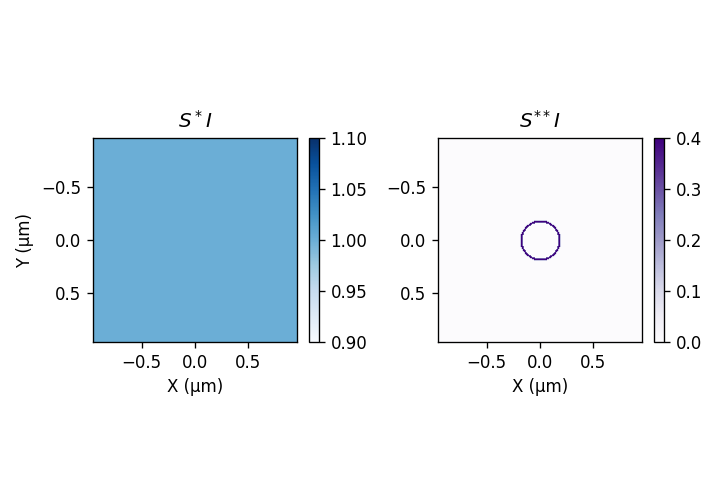

In [4]:
# visulaization of U-V IC:
U, V = get_initial_seed(20,0.4) # relaxing state ,0.4,0.3

fig, ax = plt.subplots(figsize = (6,4),dpi=150)

physical_boundaries = [Xm,XM,Ym,YM] # in um

ax = plt.subplot(121)
ax.set_title(r'$S^*I$')
im1 = ax.imshow(U, cmap='Blues',extent =physical_boundaries)

ax.set_xlabel('X (μm)')
ax.set_ylabel('Y (μm)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)

clb = fig.colorbar(im1, cax=cax, orientation='vertical')
#clb.set_label(label='Concentration of U')

ax = plt.subplot(122)
ax.set_title(r'$S^{**}I$')
im2 = ax.imshow(V, cmap='Purples',extent = physical_boundaries)
ax.set_xlabel('X (μm)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)

clb = fig.colorbar(im2, cax=cax, orientation='vertical')
#clb.set_label(label='Concentration of V')
plt.tight_layout()

#get_annuus_diameter(V>0.2,115)

In [5]:
def laplacian_c_2d(C_ar,D_ar):    
    
    C_c  = C_ar[1:-1, 1:-1]
    C_ym = C_ar[0:-2, 1:-1]    
    C_yp = C_ar[2:  , 1:-1]
    
    D_c  = D_ar[1:-1, 1:-1]
    D_ym = D_ar[0:-2, 1:-1]    
    D_yp = D_ar[2:  , 1:-1]
    
    lap_y = ((D_yp + D_c)*(C_yp-C_c)/(2*dy) + (D_ym + D_c)*(C_ym-C_c)/(2*dy))/(dy)
    
    C_xp = C_ar[1:-1,   2:]
    C_xm = C_ar[1:-1, 0:-2]
    
    D_xp = D_ar[1:-1,   2:]
    D_xm = D_ar[1:-1, 0:-2]
    
    lap_x = ((D_xp + D_c)*(C_xp-C_c)/(2*dx) + (D_xm + D_c)*(C_xm-C_c)/(2*dx))/(dx)

    return (lap_y+lap_x)

def hill_func(C_cr,lam,c):
    h = C_cr**lam/(C_cr**lam+c**lam)
    return(h)

In [11]:
from tqdm import tqdm_notebook

f      = 0.048          # equilibrium rate constant  
k_sol  = 0.116         # solidification rate

I_cr = 3              # quenching parameters
h = 15

Ds1i = 0.09#0.09            # diffusion constants 
Ds2i = 0.035
Di   = 0.24

T = 1600 #1900
n = int(T/dt)        

S1I, S2I = get_initial_seed(5//dx,0.4) # 4/dx!!

S3 = np.zeros(np.shape(U))
I  = np.zeros(np.shape(U)) 
uni = np.ones(np.shape(U))
sol = 1*np.ones(np.shape(U))

sigma = 1

for i in tqdm_notebook(range(n)):      
    
    deltaS1I = laplacian_c_2d(S1I,Ds1i*sol)
    deltaS2I = laplacian_c_2d(S2I,Ds2i*sol)
    deltaI   = laplacian_c_2d(I,Di*sol)

    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)
    
    # Neumans b.c. 
    for Z in (S1I, S2I, S3, I):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]
S3_1 = np.copy(S3)
S2I_1 = np.copy(S2I)
I_1 = np.copy(I)

/home/epsilon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6400 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


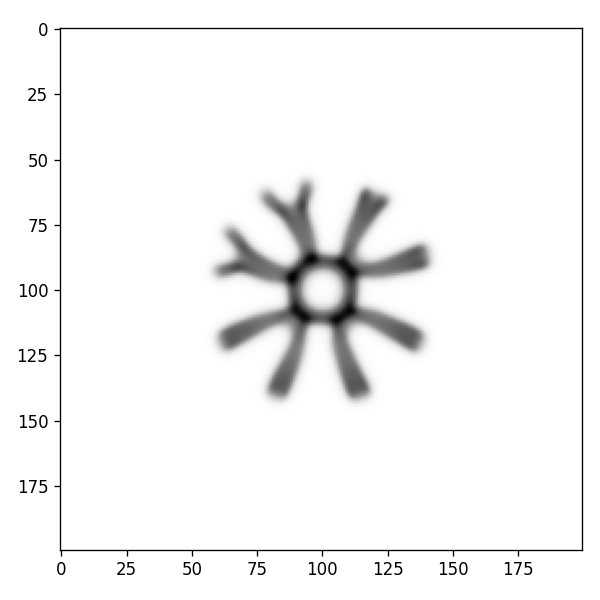

In [12]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)
ax = plt.subplot(111)

im = ax.imshow(S3,cmap='Greys')#,vmax=55)#,interpolation='gaussian')

plt.tight_layout()

In [13]:
from tqdm import tqdm_notebook

f      = 0.0475          # equilibrium rate constant  
k_sol  = 0.14         # solidification rate

I_cr = 2.6              # quenching parameters
h = 60

Ds1i = 0.12            # diffusion constants 
Ds2i = 0.003
Di   = 0.24#0.2

ki=0#0.02

T = 1200 #1500
n = int(T/dt)        

S1I = np.ones(np.shape(U))
S2I =S2I_1#0.4*1*mask
#S1I, S2I = get_initial_seed(4//dx,0.4) # relaxing state ,0.4,0.3 # relaxing state

S3 = np.zeros(np.shape(U))
I  = I_1#np.zeros(np.shape(U))
uni = np.ones(np.shape(U))
sol = 1*np.ones(np.shape(U))

sigma = 1

for i in tqdm_notebook(range(n)):      
    
    deltaS1I = laplacian_c_2d(S1I,Ds1i*sol)
    deltaS2I = laplacian_c_2d(S2I,Ds2i*sol)
    deltaI   = laplacian_c_2d(I,Di*sol)

    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0-ki*I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)
    
    # Neumans b.c. 
    for Z in (S1I, S2I, S3, I):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]
        
#S3_1 = np.copy(S3)

/home/epsilon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


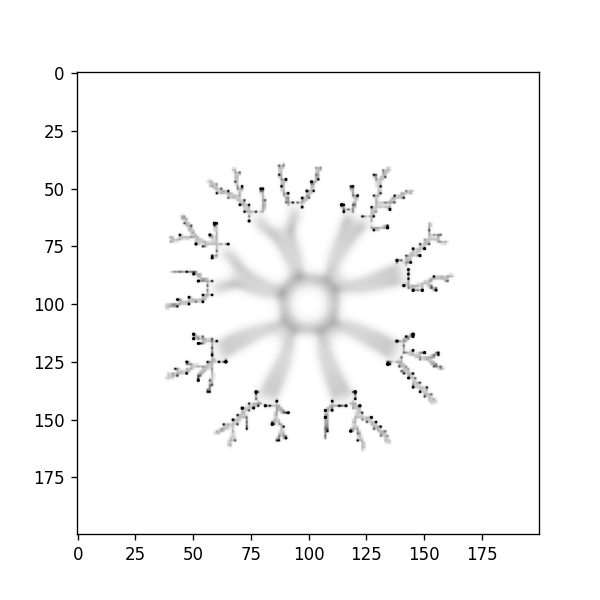

In [14]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)
ax = plt.subplot(111)

im = ax.imshow(S3+S3_1,cmap='Greys',vmin=0.5,vmax=46)#,interpolation='gaussian')